# Our algorithm

In [116]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time

## Prepare dataset

In [117]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/image_old/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]

Number of frames: 50


## 1. Identification

In [ ]:
from src.identification import HypothesisIdentifier, SimpleContourIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from src.cores.polar_description_vector import ShapeVector, construct_shape_vector
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10

# Implementation of storm object
RADII = [20, 40, 60, 80, 100, 120]
NUM_SECTORS = 8
DENSITY = 0.05

class ShapeVectorStorm(StormObject):
    shape_vectors: list[ShapeVector]
    # coords: np.ndarray

    def __init__(
            self, polygon: Polygon, global_contours: list[np.ndarray], id: str = "",
            density: float = DENSITY, radii: list[float] = RADII, num_sectors: int = NUM_SECTORS
        ):
        # initialize with the contour and the id
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([self.contour])[0]
        coords = self._sample_particles(contour, density)

        # create the shape vectors
        vectors = [construct_shape_vector(
            polygons=global_contours, point=coord, radii=radii, num_sectors=num_sectors
        ) for coord in coords]
        self.shape_vectors = [ShapeVector(
            coord=(coord[0], coord[1]), vector=vector
        ) for coord, vector in zip(coords.reshape(-1, 2), vectors)]
    
    def copy(self) -> "ShapeVectorStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def make_move(self, displacement: np.ndarray):
        dx, dy = displacement
        self.contour = translate(self.contour, xoff=dx, yoff=dy)
        for vector in self.shape_vectors:
            vector.coord = vector.coord[0] + dx, vector.coord[1] + dy
    
    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.shape_vectors)
    
    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # cluster them 
        n_clusters = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters)
        k_means.fit(points)

        return k_means.cluster_centers_.astype(np.int64)[:, ::-1]   # revert the coord order.

Processing images and detecting storms: 100%|██████████| 50/50 [08:42<00:00, 10.44s/it]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 6
Time: 2025-01-08 03:16:44 | Detected storms: 5
Time: 2025-01-08 03:22:45 | Detected storms: 7
Time: 2025-01-08 03:28:45 | Detected storms: 11
Time: 2025-01-08 03:34:45 | Detected storms: 9
Time: 2025-01-08 03:40:45 | Detected storms: 12
Time: 2025-01-08 03:46:46 | Detected storms: 14
Time: 2025-01-08 03:52:46 | Detected storms: 10
Time: 2025-01-08 03:58:46 | Detected storms: 10
Time: 2025-01-08 04:04:46 | Detected storms: 10
Time: 2025-01-08 04:10:47 | Detected storms: 9
Time: 2025-01-08 04:16:47 | Detected storms: 8
Time: 2025-01-08 04:22:47 | Detected storms: 16
Time: 2025-01-08 04:28:47 | Detected storms: 12
Time: 2025-01-08 04:34:48 | Detected storms: 13
Time: 2025-01-08 04:40:48 | Detected storms: 8
Time: 2025-01-08 04:46:48 | Detected storms: 6
Time: 2025-01-08 04:52:48 | Detected storms: 14
Time: 2025-01-08 04:58:49 | Detected storms: 13
Time: 2025-01-08 05:04:49 | Detected storms: 12
Time: 2025-01-08 05:10:49 |

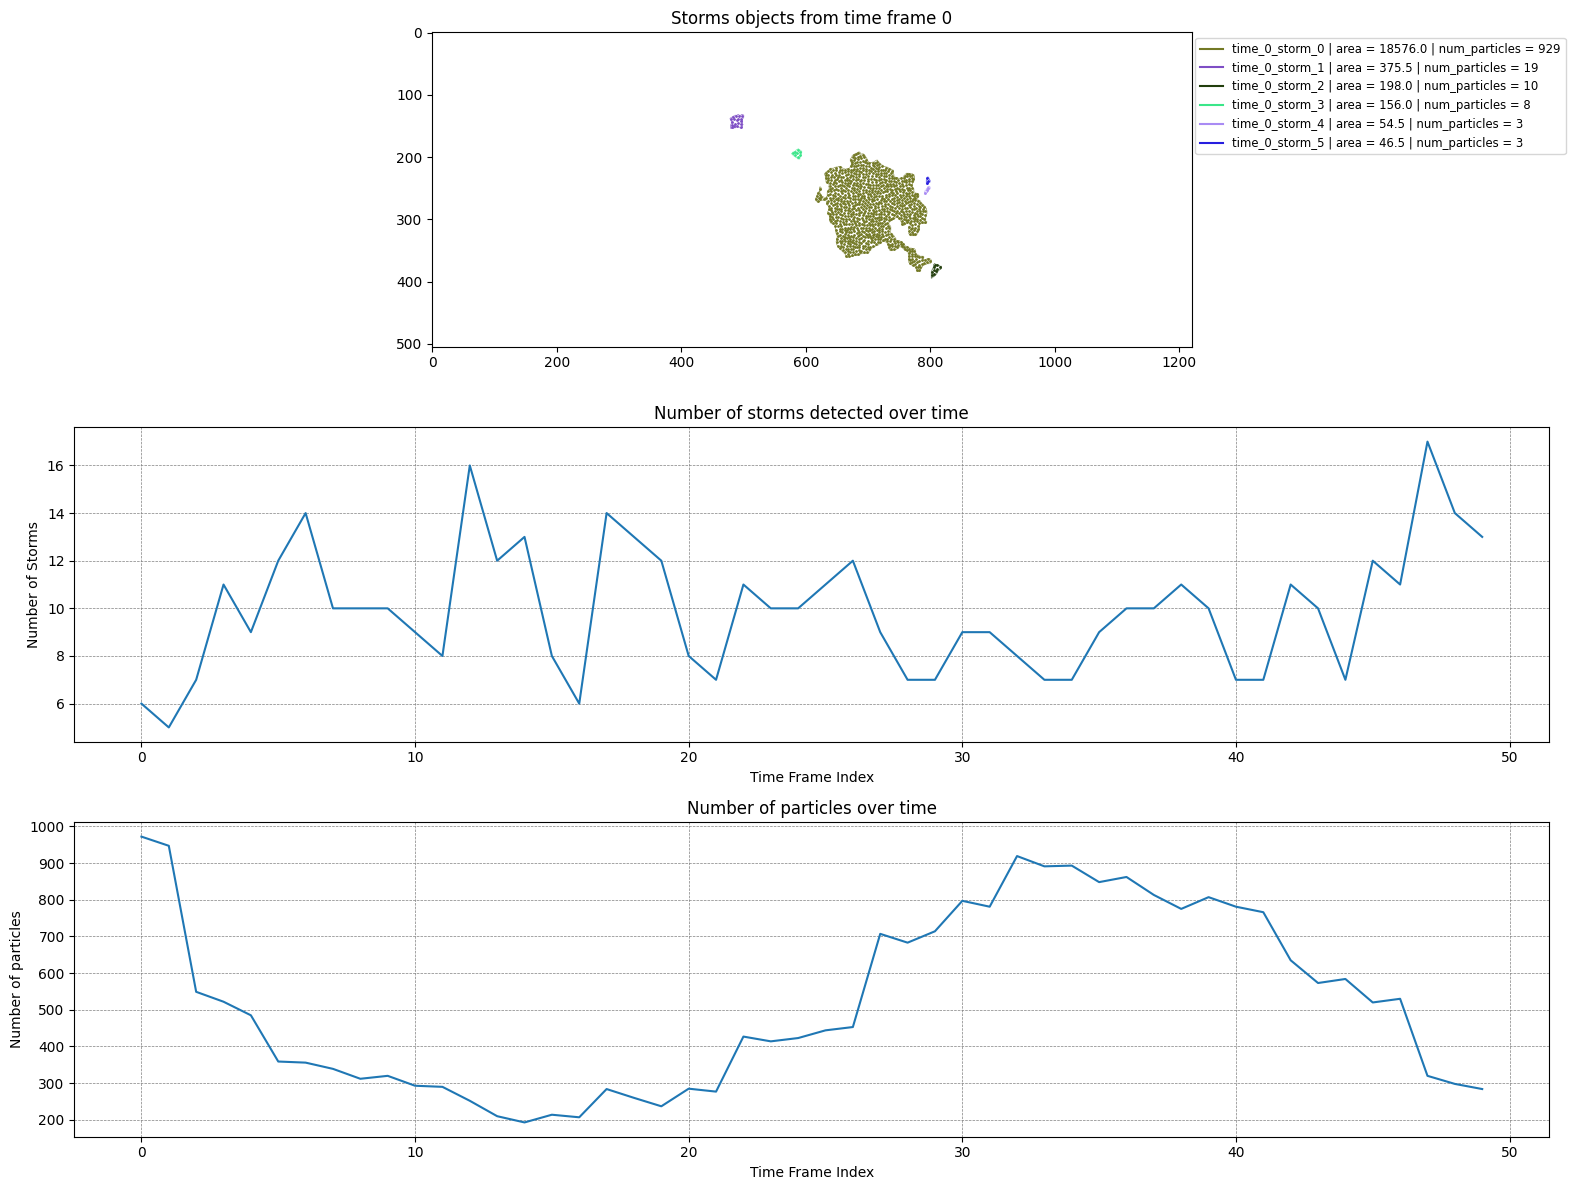

In [ ]:
# identifier = HypothesisIdentifier()
identifier = SimpleContourIdentifier()
storms_map_time_lst: list[ShapeVectorStorm] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    # contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA, 
    #                                 distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    storms = [ShapeVectorStorm(
                polygon=polygon, 
                id=f"time_{time_idx}_storm_{idx}",
                global_contours=contours
            ) for idx, polygon in enumerate(polygons)]
    
    storms_map = StormsMap(storms, time_frame=time_frame)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(10, 14))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    coords = np.array([vector.coord for vector in storm.shape_vectors])
    x_points, y_points = coords[:, 0], coords[:, 1]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f} | num_particles = {storm.get_num_particles()}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right", fontsize='small', ncol=1)
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_particles = [sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_particles)), number_of_particles)
plt.title('Number of particles over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**: implement 2 matcher stages: `particles matching` and `storms matching`.

- **Particles matching**: match one-to-one particles using the following factors:
    + *particle distance*
    + *shape vector*

- **Storms matching**: 

In [ ]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker
from dataclasses import dataclass
import pandas as pd
from shapely.affinity import translate

@dataclass
class Particle:
    feature: ShapeVector
    storm_order: int        # order of storm in the storms_map

class ParticleMatcher(BaseMatcher):
    def _construct_disparity_matrix(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], weights: list[float]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Construct a disparity matrix for the 2 list of shape vector objects.

        Parameters:
            particle_lst1 (list[Particle]): The first list of shape vectors.
            particle_lst2 (list[Particle]): The second list of shape vectors.
            weights (list[float]): the list of non-negative and sum-to-1 weights.

        Returns:
            cost_matrix, distance_matrix (tuple[np.ndarray, np.ndarray]): The constructed disparity matrix and distance matrix for later verification.
        """
        assert all([all([w >= 0 for w in weights]), np.sum(weights) == 1]), "weights must not be negative and must sum to 1."
        coord_1 = np.array([np.array(p.feature.coord) for p in particle_lst1])
        coord_2 = np.array([np.array(p.feature.coord) for p in particle_lst2])
        distance_matrix = np.linalg.norm(coord_1[:, None, :] - coord_2[None, :, :], axis=2)

        shape_vector_1 = np.array([p.feature.vector for p in particle_lst1])
        shape_vector_2 = np.array([p.feature.vector for p in particle_lst2])
        shape_diff_matrix = np.sqrt(np.abs(shape_vector_1[:, None, :] - shape_vector_2[None, :, :]).sum(axis=2))

        return weights[0] * distance_matrix + weights[1] * shape_diff_matrix, distance_matrix

    def match_particles(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle],
            maximum_displacement: float, weights: list[float] = [0.5, 0.5]
        ) -> np.ndarray:
        """
        Match particles between 2 time frame.

        Args:
            particle_lst1 (list[Particle]): particles in the 1st frame.
            particle_lst1 (list[Particle]): particles in the 2nd frame.
        
        Returns
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched particles.
        """
        cost_matrix, displacement_matrix = self._construct_disparity_matrix(particle_lst1, particle_lst2, weights=weights)
        invalid_mask = displacement_matrix > maximum_displacement

        cost_matrix = cost_matrix + invalid_mask.astype(np.float64) * 3000      # add penalty to those violated
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & np.logical_not(invalid_mask))
    

class StormMatcher(BaseMatcher):
    max_velocity: float
    matching_threshold: float       # minimum probability threshold for matching between 2 storms
    particle_matcher: ParticleMatcher

    def __init__(self, max_velocity: float, matching_threshold: float):
        self.max_velocity = max_velocity
        self.matching_threshold = matching_threshold
    
    def _construct_disparity_matrix(self, object_lst1, object_lst2):
        pass

    def _resolve_displacement(
            self, displacements: list[np.ndarray], prev_storm: ShapeVectorStorm, curr_storm: ShapeVectorStorm
        ) -> np.ndarray:
        """
        Generate a final displacement from the list of particles pair displacement.
        """
        def compute_overlapping(displ: np.ndarray):
            dx, dy = displ
            pred_pol = translate(prev_storm.contour, xoff=dx, yoff=dy)

            return pred_pol.intersection(curr_storm.contour).area

        best_displacement = np.mean(displacements, axis=0)
        best_score = compute_overlapping(best_displacement)

        for num_cluster in range(2, 6):
            if len(displacements) <= num_cluster * 2:
                break
            else:
                # Build a cluster and extract the group with largest count.
                k_means = KMeans(n_clusters=num_cluster, random_state=2025)
                labels = k_means.fit_predict(displacements)

                unique_labels, counts = np.unique(labels, return_counts=True)
                largest_cluster_label = unique_labels[np.argmax(counts)]
                
                # Extract displacements in that cluster.
                optimal_displacement = k_means.cluster_centers_[largest_cluster_label]
                score = compute_overlapping(optimal_displacement)

                if score > best_score:
                    best_displacement = optimal_displacement
                    best_score = score
        
        return best_displacement

    def match_storms(
            self, storms_map1: StormsMap, storms_map2: StormsMap
        ) -> tuple[np.ndarray, list, list]:
        """
        Match storms between 2 time frame.

        Args:
            storm_map1 (StormsMap): storm map in the 1st frame.
            storm_map2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            tuple[np.ndarray, list, list]:
                assignments (nd.ndarray): list of pairs of corresponding id of 2 storms.
                probability_matrix (list): list of score of corresponding assignment.
                displacements (list): list of displacement of corresponding assignment.
        """
        particles_prev: list[Particle] = [Particle(feature=v, storm_order=idx) for idx, storm in enumerate(storms_map1.storms)\
                          for v in storm.shape_vectors]
        particles_curr: list[Particle] = [Particle(feature=v, storm_order=idx) for idx, storm in enumerate(storms_map2.storms)\
                          for v in storm.shape_vectors]
        
        dt = (storms_map2.time_frame - storms_map1.time_frame).seconds / 3600
        maximum_displacement = self.max_velocity * dt
        
        if len(particles_prev) == 0 or len(particles_curr) == 0:
            return [], [], []

        self.particle_matcher = ParticleMatcher()
        particle_assignments = self.particle_matcher.match_particles(
                particles_prev, particles_curr, maximum_displacement=maximum_displacement
            )
        
        # map particles assignment back to storm.
        particles_id_prev = [p.storm_order for p in particles_prev]
        particles_id_curr = [p.storm_order for p in particles_curr]

        mapping_displacements = {curr_idx: {prev_idx: [] for prev_idx in range(len(storms_map1.storms))}\
                                 for curr_idx in range(len(storms_map2.storms))}
        
        for (p_prev_idx, p_curr_idx) in particle_assignments:
            p_prev = particles_prev[p_prev_idx].feature.coord
            p_curr = particles_curr[p_curr_idx].feature.coord
            displacement = np.array(p_curr) - np.array(p_prev)

            mapping_displacements[particles_id_curr[p_curr_idx]][particles_id_prev[p_prev_idx]].append(displacement)
        
        matched_count_mapping = {k_curr: {k_prev: len(v_prev) for k_prev, v_prev in v_curr.items()} \
                                 for k_curr, v_curr in mapping_displacements.items()}

        count_df = pd.DataFrame(matched_count_mapping)

        num_particles_prev = pd.Series([s.get_num_particles() for s in storms_map1.storms], count_df.index)
        num_particles_curr = pd.Series([s.get_num_particles() for s in storms_map2.storms], count_df.columns)

        p_A = count_df.div(num_particles_prev, axis=0)
        p_B = count_df.div(num_particles_curr, axis=1)

        p = np.max([p_A, p_B], axis=0)
        assignments = np.argwhere(p > self.matching_threshold)
        return assignments, [np.array(p_B)[prev_idx][curr_idx] for prev_idx, curr_idx in assignments], \
            [self._resolve_displacement(np.array(mapping_displacements[curr_idx][prev_idx]), \
                    storms_map1.storms[prev_idx], storms_map2.storms[curr_idx]) for prev_idx, curr_idx in assignments]

In [ ]:
MAX_VELOCITY = 500
MATCHING_THRESHOLD = 0.45

matcher = StormMatcher(MAX_VELOCITY, MATCHING_THRESHOLD)
assignments, scores, displacements = matcher.match_storms(storms_map_time_lst[1], storms_map_time_lst[2])

for (prev_idx, curr_idx), score, displacement in zip(assignments, scores, displacements):
    print(f"Matching: {prev_idx} -> {curr_idx}")
    print(f"Score: {score}")
    print(f"Displacecment: {displacement}")
    print("-" * 50)

Matching: 0 -> 0
Score: 1.0
Displacecment: [-1.29475983 -1.3558952 ]
--------------------------------------------------
Matching: 0 -> 1
Score: 1.0
Displacecment: [-22.90909091 -13.18181818]
--------------------------------------------------
Matching: 0 -> 4
Score: 1.0
Displacecment: [ 2.6 -4. ]
--------------------------------------------------
Matching: 1 -> 2
Score: 0.9444444444444444
Displacecment: [ 0.33333333 -0.5       ]
--------------------------------------------------
Matching: 3 -> 5
Score: 0.5714285714285714
Displacecment: [-15.25 -15.  ]
--------------------------------------------------
Matching: 4 -> 5
Score: 0.2857142857142857
Displacecment: [-11.   -7.5]
--------------------------------------------------


### 2.2 Implementation of `TrackHistory`

In [122]:
from shapely.affinity import translate

class TrackingHistory(BaseTrackingHistory):
    def __init__(self, storms_map: StormsMap):
        self.tracks = [self._initialize_track(storm, storms_map.time_frame) for storm in storms_map.storms]
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: ShapeVectorStorm, time_frame: datetime):
        return {"storm_lst": [storm], "frame": [time_frame], "movement": []}

    def _get_track(self, storm_id: str) -> tuple[dict, float]:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple(dict, float))
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id], track_id in self.active_list

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)
    
    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ShapeVectorStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track, is_active = self._get_track(storm_id)
        if not is_active:
            print(f"⚠️ Storm has been expired")
            
        curr_storm: ShapeVectorStorm = track["storm_lst"][-1]

        velocity_lst = track["movement"]
        if len(velocity_lst) == 0:      # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        displacement = self._interpolate_velocity(velocity_lst) * dt
        new_storm = curr_storm.copy()
        new_storm.make_move(displacement)

        return new_storm

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, score.
        """
        weights = np.array([s["score"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 1e-8
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]

    def update(
            self, curr_mapping: dict, prev_storms_map: StormsMap, curr_storms_map: StormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            curr_mapping (dict): key -> idx of curr storm; items -> list[(idx, score, displacement) of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        for curr_idx, matched in curr_mapping.items():
            curr_storm = curr_storms_map.storms[curr_idx]

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)
            
            # Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_score = 0
                track_id = None

                for prev_idx, score, displacement in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)[0]          # get the corresponding track
                    if score > max_score:
                        max_score = score
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area will be extended, others are terminated
                    
                    merge_lst.append({
                        "score": score,
                        "movement": track["movement"] + [displacement / dt]
                    })
                
                current_track = self.tracks[track_id]
                
                movement_history = self._handle_merge(merge_lst)    # resolve the history
                current_track["storm_lst"].append(curr_storm)
                current_track["movement"] = list(movement_history)  # update the movement
                current_track["frame"].append(curr_time)

                # update storm dict & active lst
                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
            
            # Case 3: only 1 parent storm
            else:
                prev_idx, _, displacement = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]

                # copy the previous track into the new, then update parameters.
                new_track = deepcopy(self._get_track(prev_storm.id)[0])
                self.tracks.append(new_track)
                new_track["storm_lst"].append(curr_storm)
                new_track["movement"].append(displacement / dt)
                new_track["frame"].append(curr_time)

                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)

        self.active_list = sorted(active_lst)

    def print_tracks(self):
        for id, track in enumerate(self.tracks):
            print(f"Track {id:2d}. " + " -> ".join(storm.id for storm in track["storm_lst"]))
            print(f"Lifespan: {len(track["frame"])}")
            print(f"Last track: {track["frame"][-1].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [ ]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: StormMatcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float, matching_threshold: float):
        self.matcher = StormMatcher(max_velocity, matching_threshold)
        
    def fit(self, storms_map_time_lst: list[StormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        # return csi_scores, far_scores, pod_scores, frames

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour
            
            if test:
                pred_storms_map = StormsMap([
                    self.tracker.forecast(storm.id, dt) for storm in prev_storms_map.storms
                ], time_frame=curr_storms_map.time_frame)

                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # match using Hungarian algorithm
            ## the match result already includes split & merge
            assignments, scores, displacements = self.matcher.match_storms(prev_storms_map, curr_storms_map)
            mapping_curr = {curr_idx: [] for curr_idx in range(len(curr_storms_map.storms))}

            for (prev_idx, curr_idx), score, displacement in zip(assignments, scores, displacements):
                mapping_curr[int(curr_idx)] = [(int(prev_idx), score, displacement)]

            self.tracker.update(mapping_curr, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames

    def predict(self, storm: ShapeVectorStorm, dt: float):
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [124]:
MAX_VELOCITY = 500  # unit: pixel/hr
MATCHING_THRESHOLD = 0.45

tracker = Tracker(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks()

Track  0. time_0_storm_0
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  1. time_0_storm_1
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  2. time_0_storm_2
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  3. time_0_storm_3
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  4. time_0_storm_4
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  5. time_0_storm_5
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  6. time_0_storm_2 -> time_1_storm_0
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Track  7. time_0_storm_1 -> time_1_storm_1
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Trac

In [125]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

# indexes = range(len(bm_pod_scores))
# scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
# titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

# plt.figure(figsize=(12, 6))

# for i, title in enumerate(titles):
#     plt.subplot(3, 1, i+1)
#     plt.plot(indexes, scores[i], label=title)
#     plt.title(title)
#     plt.xlabel('Time Frame Index')
#     plt.ylabel('Score')
#     plt.ylim(0, 1)
#     plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

# plt.tight_layout()
# plt.show()

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9424 | FAR: 0.0831 | CSI: 0.8683
	Time 2025-01-08 03:22:45 | POD: 0.8285 | FAR: 0.5211 | CSI: 0.4357
	Time 2025-01-08 03:28:45 | POD: 0.8986 | FAR: 0.1521 | CSI: 0.7739
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1646 | CSI: 0.7605
	Time 2025-01-08 03:40:45 | POD: 0.6881 | FAR: 0.4947 | CSI: 0.4111
	Time 2025-01-08 03:46:46 | POD: 0.8744 | FAR: 0.1409 | CSI: 0.7648
	Time 2025-01-08 03:52:46 | POD: 0.4498 | FAR: 0.5685 | CSI: 0.2824
	Time 2025-01-08 03:58:46 | POD: 0.8317 | FAR: 0.2298 | CSI: 0.6663
	Time 2025-01-08 04:04:46 | POD: 0.8060 | FAR: 0.1808 | CSI: 0.6842
	Time 2025-01-08 04:10:47 | POD: 0.7158 | FAR: 0.3455 | CSI: 0.5195
	Time 2025-01-08 04:16:47 | POD: 0.8580 | FAR: 0.1429 | CSI: 0.7506
	Time 2025-01-08 04:22:47 | POD: 0.4297 | FAR: 0.6329 | CSI: 0.2468
	Time 2025-01-08 04:28:47 | POD: 0.7437 | FAR: 0.3793 | CSI: 0.5113
	Time 2025-01-08 04:34:48 | 

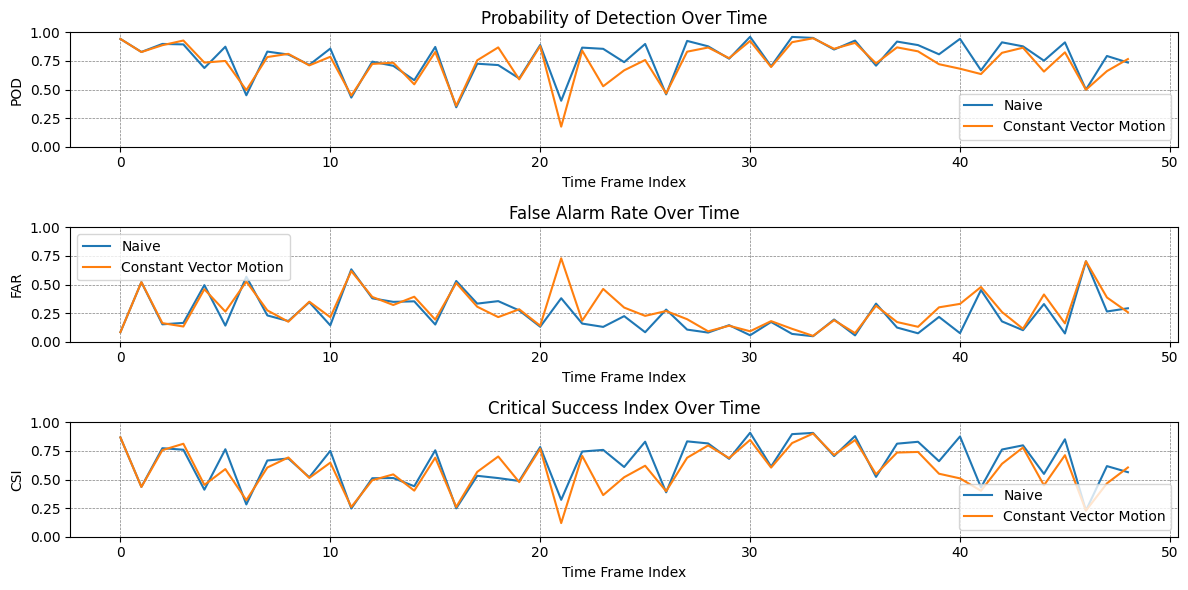

In [126]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()